In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
import lal

In [4]:
import lalsimulation as lalsim

In [5]:
from scrinet.interfaces import lalutils

In [6]:
from scipy.fftpack import fft, ifft, fftfreq, rfft, rfftfreq, fftshift, ifftshift

In [7]:
import phenom

In [8]:
def planck_taper(times, t1, t2):
    """times: array of times
    t1. for t<=t1 then return 0
    t2. for t>=t2 then return 1
    else return 1./(np.exp((t2-t1)/(t-t1)+(t2-t1)/(t-t2))+1)"""
    tout = []
    for t in times:
        if t<=t1:
            tout.append(0.)
        elif t>=t2:
            tout.append(1.)
        else:
            tout.append(1./(np.exp((t2-t1)/(t-t1)+(t2-t1)/(t-t2))+1))
    return np.array(tout)

In [9]:
def td_amp_scale(mtot, distance):
    """
    mtot in solar masses
    distance in m
    M*G/c^2 * M_sun / dist
    """
    return mtot * lal.MRSUN_SI / distance

In [10]:
def fd_amp_scale(mtot, distance):
    """
    mtot in solar masses
    distance in m
    M*G/c^2 * M_sun / dist
    """
    return mtot * lal.MRSUN_SI * mtot * lal.MTSUN_SI / distance

In [11]:
def conditioned_complex_fft(t, y, t12=None, t34=None, pad_fac=10):
    """
    computes the fft of complex data y
    t {array}, times in units of seconds
    t12, t34 {2-tuple of floats: None}
        t1,t2 = (t12): start and end times of beginning planck taper
        t3,t4 = (t34): start and end times of end planck taper
    pad_fac {'int': 10}
        factor to pad by. split evenly left and right
    returns:
        frequencies, ytilde, window
    """
    y = y.copy()
    dt = t[1]-t[0]
    window = np.ones(len(y))
    
    if t12:
        t1, t2 = t12
        start_window = planck_taper(t, t1, t2)
        window *= start_window
    if t34:
        t3, t4 = t34
        end_window = 1. - planck_taper(t, t3, t4)
        window *= end_window
        
    y *= window
    
    pan_len = int(len(t)*(pad_fac/2))
    
    y = np.pad(y, (pan_len, pan_len), 'constant', constant_values=(0, 0))

    ytilde = fft(y) * dt / 2 # factor of 2 because y is complex
    frequencies = fftfreq(len(y), dt)
    
    return frequencies, ytilde, window

In [117]:
def conditioned_complex_ifft(f, htilde, tshift=0, f12=None, f34=None):
    """
    computes the ifft of complex data htilde
    f {array}, frequency in units of Hz
    f12, f34 {2-tuple of floats: None}
        f1,f2 = (f12): start and end times of beginning planck taper
        f3,f4 = (f34): start and end times of end planck taper
        applied symmetrically about zero to both positive and negative frequencies
    returns:
        times, ht, window
    """
    htilde = htilde.copy()
    phasefac = np.exp(2.0 * np.pi * 1.j * f * tshift);
    htilde *= phasefac
    df = f[1]-f[0]
    
    
    window = np.ones(len(htilde))
    
    if f12:
        f1, f2 = f12
        mask = f>0
        start_window = planck_taper(f[mask], f1, f2)
        window[mask] *= start_window
        mask = f<=0
        start_window = 1-planck_taper(f[mask], -f2, -f1)
        window[mask] *= start_window
    if f34:
        f3, f4 = f34
        mask = f>0
        end_window = 1.-planck_taper(f[mask], f3, f4)
        window[mask] *= end_window
        mask = f<=0
        end_window = planck_taper(f[mask], -f4, -f3)
        window[mask] *= end_window
        
    htilde *= window
    
    ht = ifft(htilde * len(htilde)) * df * 2
    times = fftfreq(len(htilde), df)
    
#     return ifftshift(times), ht, window
    return ifftshift(times), ht, window

In [13]:
def conditioned_real_fft(t, y, t12=None, t34=None, pad_fac=10):
    """
    computes the fft of data y
    t {array}, times in units of seconds
    t12, t34 {2-tuple of floats: None}
        t1,t2 = (t12): start and end times of beginning planck taper
        t3,t4 = (t34): start and end times of end planck taper
    pad_fac {'int': 10}
        factor to pad by. split evenly left and right
    returns:
        frequencies, ytilde, window
    """
    y = y.copy()
    dt = t[1]-t[0]
    window = np.ones(len(y))
    
    if t12:
        t1, t2 = t12
        start_window = planck_taper(t, t1, t2)
        window *= start_window
    if t34:
        t3, t4 = t34
        end_window = 1.-planck_taper(t, t3, t4)
        window *= end_window
        
    y *= window
    
    pan_len = int(len(t)*(pad_fac/2))
    
    y = np.pad(y, (pan_len, pan_len), 'constant', constant_values=(0, 0))

    ytilde = rfft(y) * dt
    frequencies = rfftfreq(len(y), dt)
    
    return frequencies, ytilde, window

In [14]:
modes_params = lalutils.gen_td_modes_wf_params(distance=1)

In [15]:
t, hlms = lalutils.gen_td_modes_wf(modes_params, modes=[[2,2]])

In [16]:
td_amp_scale(modes_params['m1']+modes_params['m2'], modes_params['r'])

147662.50614046495

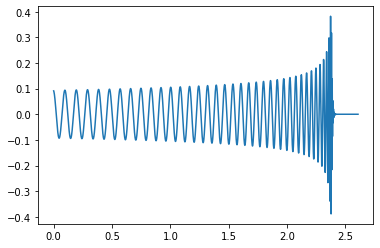

In [17]:
plt.figure()
plt.plot(t, hlms[(2,2)].real/td_amp_scale(modes_params['m1']+modes_params['m2'], modes_params['r']))

In [18]:
?lal.SpinWeightedSphericalHarmonic

Docstring: SpinWeightedSphericalHarmonic(REAL8 theta, REAL8 phi, int s, int l, int m) -> COMPLEX16
Type:      builtin_function_or_method


In [19]:
lal.SpinWeightedSphericalHarmonic(0,0,-2,2,2)

(0.6307831305050401+0j)

/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


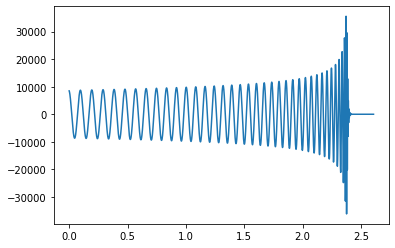

In [20]:
plt.figure()
plt.plot(t, hlms[(2,2)].real * lal.SpinWeightedSphericalHarmonic(0,0,-2,2,2))

In [21]:
modes_params_td = lalutils.gen_td_wf_params(distance=1, f_min=10, approximant=lalsim.SEOBNRv4P)

In [22]:
tp, amp, phase = lalutils.gen_td_wf(modes_params_td, t_min=-10000)

/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


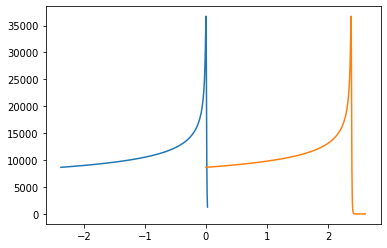

In [23]:
plt.figure()
plt.plot(phenom.MtoS(tp, 100), amp)
plt.plot(t, np.abs(hlms[(2,2)]) * lal.SpinWeightedSphericalHarmonic(0,0,-2,2,2))
# plt.xlim(2,2.5)

In [24]:
modes_params_fd = lalutils.gen_fd_wf_params(distance=1, f_min=5, approximant=lalsim.IMRPhenomD)

In [25]:
modes_params_fd

{'m1': 50,
 'm2': 50,
 'S1x': 0,
 'S1y': 0,
 'S1z': 0,
 'S2x': 0,
 'S2y': 0,
 'S2z': 0,
 'distance': 1,
 'inclination': 0,
 'phiRef': 0,
 'longAscNodes': 0,
 'eccentricity': 0,
 'meanPerAno': 0,
 'deltaF': 0.0625,
 'f_min': 5,
 'f_max': 200,
 'f_ref': 30,
 'LALpars': None,
 'approximant': 70}

In [27]:
fd_f, fd_amp, fd_phase = lalutils.gen_fd_wf(modes_params_fd, f_min=0, f_max=2000)

In [28]:
my_f, my_htilde, window = conditioned_complex_fft(t, hlms[(2,2)] * lal.SpinWeightedSphericalHarmonic(0,0,-2,2,2), t12=(0, 0.5), t34=(2.5,2.8))
# my_f, my_htilde, window = conditioned_complex_fft(t, hlms[(2,2)], t12=(0, 0.5), t34=(2.5,2.8))

/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


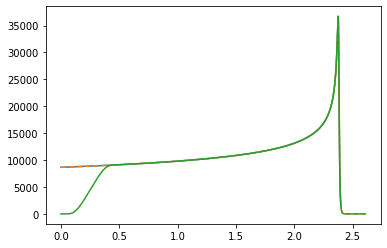

In [29]:
plt.figure()
plt.plot(phenom.MtoS(tp-tp[0], 100), amp)
plt.plot(t, np.abs(hlms[(2,2)]) * lal.SpinWeightedSphericalHarmonic(0,0,-2,2,2), ls='--')
plt.plot(t, np.abs(hlms[(2,2)]) * lal.SpinWeightedSphericalHarmonic(0,0,-2,2,2)*window)
# plt.xlim(2,2.5)

In [30]:
plt.figure()
plt.plot(fd_f, fd_amp)
# plt.plot(phenom.HztoMf(my_f, 100), np.abs(my_htilde), ls='--')
plt.plot(my_f, np.abs(my_htilde), ls='--')
plt.yscale('log')
# plt.xlim(-0.2,0.2)
plt.xlim(-300,300)

(-300, 300)

(-300, 300)

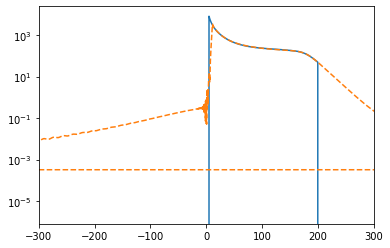

In [31]:
plt.figure()
plt.plot(fd_f, fd_amp)
# plt.plot(-phenom.HztoMf(my_f, 100), np.abs(my_htilde), ls='--')
plt.plot(-my_f, np.abs(my_htilde), ls='--')
plt.yscale('log')
# plt.xlim(0,0.2)
plt.xlim(-300,300)

In [32]:
my_f[1]-my_f[0]

0.034849193857148936

In [33]:
test_y = np.ones(len(my_f))*1.j

In [34]:
myt, myht, f_window = conditioned_complex_ifft(my_f, test_y, f12=(10,50), f34=(100,150))

/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


In [35]:
plt.figure()
plt.plot(my_f, np.abs(test_y))
plt.plot(my_f, np.abs(test_y)*f_window)
plt.xlim(-200,200)

(-200, 200)

In [36]:
myt, myht, f_window = conditioned_complex_ifft(my_f, my_htilde, f12=(4,5), f34=(250,300))

/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


(-200, 200)

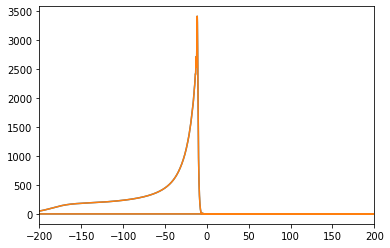

In [37]:
plt.figure()
plt.plot(my_f, np.abs(my_htilde))
plt.plot(my_f, np.abs(my_htilde)*f_window)
plt.xlim(-200,200)

In [38]:
phenom.MftoHz(fd_f, 100)[1]-phenom.MftoHz(fd_f, 100)[0]

126.89090219821868

In [39]:
phenom.MftoHz(0.025, 100)

50.75636087928748

In [40]:
# myt_inv_lal, myht_inv_lal, _ = my_ifft(phenom.MftoHz(fd_f, 100), fd_amp*np.exp(1.j*fd_phase), tshift=0.5, f12=(6,10))
myt_inv_lal, myht_inv_lal, _ = conditioned_complex_ifft(fd_f, fd_amp*np.exp(1.j*fd_phase), tshift=0.5, f12=(6,10))


In [41]:
len(myt)

117535

In [42]:
plt.figure(figsize=(14,4))
# plt.plot(myt-1.071, myht.real)
plt.plot(myt-1.071, np.abs(myht))
plt.plot(myt_inv_lal-7.5, np.abs(myht_inv_lal))
plt.plot(phenom.MtoS(tp, 100), amp )
# plt.xlim(-5,2.4)
# plt.xlim(-0.01,0.01)

In [43]:
pars_fd = lalutils.gen_fd_wf_params(f_min=10, distance=1e3, approximant=lalsim.IMRPhenomD, f_max=1000)

In [44]:
pars_fd

{'m1': 50,
 'm2': 50,
 'S1x': 0,
 'S1y': 0,
 'S1z': 0,
 'S2x': 0,
 'S2y': 0,
 'S2z': 0,
 'distance': 1000.0,
 'inclination': 0,
 'phiRef': 0,
 'longAscNodes': 0,
 'eccentricity': 0,
 'meanPerAno': 0,
 'deltaF': 0.0625,
 'f_min': 10,
 'f_max': 1000,
 'f_ref': 30,
 'LALpars': None,
 'approximant': 70}

In [66]:
f_fd, amp_fd, phase_fd = lalutils.gen_fd_wf(pars_fd, f_min=1e-3, f_max=0.5, units="Mf")

In [67]:
plt.figure()
plt.plot(f_fd, amp_fd)
plt.yscale('log')

In [68]:
pars = lalutils.gen_td_wf_params(f_min=10, distance=1e3, approximant=lalsim.IMRPhenomD, deltaT=1./2048)

In [69]:
pars

{'m1': 50,
 'm2': 50,
 's1x': 0,
 's1y': 0,
 's1z': 0,
 's2x': 0,
 's2y': 0,
 's2z': 0,
 'distance': 1000.0,
 'inclination': 0,
 'phiRef': 0,
 'longAscNodes': 0,
 'eccentricity': 0,
 'meanPerAno': 0,
 'deltaT': 0.00048828125,
 'f_min': 10,
 'f_ref': 30,
 'params': None,
 'approximant': 70}

In [70]:
t, amp, phase = lalutils.gen_td_wf(pars, t_min=-1000, t_max=100)

In [71]:
h = amp*np.exp(-1.j*phase)

In [72]:
h_tapered = h*planck_taper(t, -1000, -500)*(1-planck_taper(t, 70, 100))
# h_tapered = np.real(h_tapered)

/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


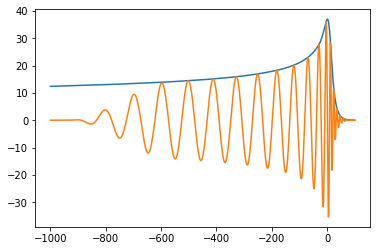

In [73]:
plt.figure()
plt.plot(t, amp)
# plt.plot(t, np.abs(h_tapered))
plt.plot(t, (h_tapered))

In [74]:
dt = t[1]-t[0]
print(dt)

0.9913351734235221


In [75]:
pan_len = len(t)*10

In [76]:
t_pad = np.pad(t, (pan_len, pan_len), 'constant', constant_values=(0, 0))
h_tapered_pad = np.pad(h_tapered, (pan_len, pan_len), 'constant', constant_values=(0, 0))

In [77]:
1./phenom.MtoS(dt, 100)

2048.000000000127

In [78]:
dt

0.9913351734235221

In [79]:
# nrtilde = dt * np.fft.fft(h_tapered)
# frequencies = np.fft.fftfreq(len(h_tapered), dt)

# nrtilde = dt * np.fft.fft(h_tapered_pad)

# df = 1./(dt * len(h_tapered_pad))

# divide by 2 for complex fft?
# convert dt from M to seconds?
nrtilde = fft(h_tapered_pad)  * phenom.MtoS(dt, 100) / 2
frequencies = fftfreq(len(h_tapered_pad), dt)


# if real then don't need factor of 2
# nrtilde = np.fft.rfft(h_tapered_pad)  * phenom.MtoS(dt, 100)
# frequencies = np.fft.rfftfreq(len(h_tapered_pad), dt)

In [80]:

nrtilde.shape

(23289,)

In [81]:
frequencies.shape

(23289,)

In [82]:
frequencies[0]

0.0

(-0.25, 0.25)

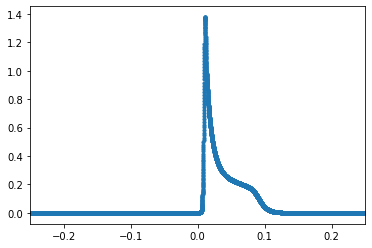

In [83]:
plt.figure()
plt.scatter(frequencies, np.abs(nrtilde), s=10)
plt.xlim(-0.25,0.25)

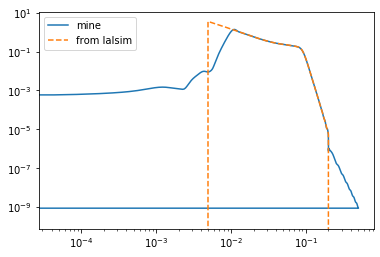

In [84]:
plt.figure()
plt.plot(frequencies, np.abs(nrtilde), label='mine')
plt.plot(f_fd, amp_fd, label='from lalsim', ls='--')
# plt.xlim(-0.25,0.25)
plt.yscale('log')
plt.xscale('log')
# plt.xlim(1e-3,0.25)
# plt.ylim(1e-2,1e4)

plt.legend()

# forward and backward fft

In [85]:
modes_params = lalutils.gen_td_modes_wf_params(distance=1)

In [86]:
t, hlms = lalutils.gen_td_modes_wf(modes_params, modes=[[2,2]])

In [87]:
td_amp_scale(modes_params['m1']+modes_params['m2'], modes_params['r'])

147662.50614046495

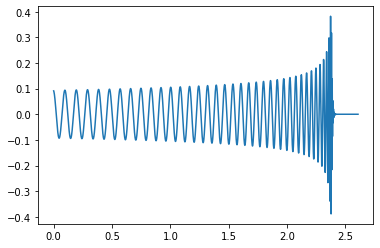

In [88]:
plt.figure()
plt.plot(t, hlms[(2,2)].real/td_amp_scale(modes_params['m1']+modes_params['m2'], modes_params['r']))

In [89]:
phenom.StoM(0.8, 100)

1624.2035481371993

In [90]:
f, htilde, window = conditioned_complex_fft(t, hlms[(2,2)], t12=(0,0.8))

/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


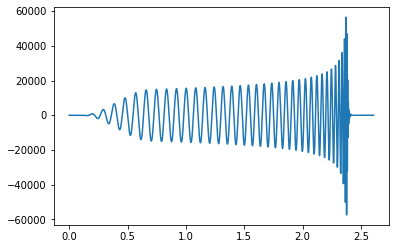

In [109]:
plt.figure()
plt.plot(t, np.real(hlms[(2,2)])*window)

In [110]:
plt.figure()
plt.plot(f, np.abs(htilde))
plt.xlim(-500,5)
plt.yscale('log')

In [121]:
# tt, htt, windowtt = conditioned_complex_ifft(f, htilde, f12=(4, 10), tshift=1.5)
tt, htt, windowtt = conditioned_complex_ifft(f, htilde, f12=(4, 10), tshift=2.1/2)

/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


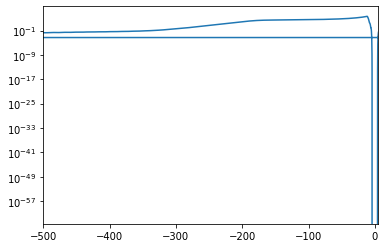

In [122]:
plt.figure()
plt.plot(f, np.abs(htilde)*windowtt)
plt.xlim(-500,5)
plt.yscale('log')

(-0.2, 0.1)

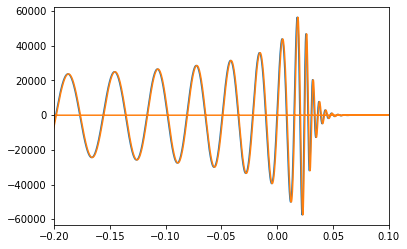

In [138]:
plt.figure()
plt.plot(t-2.355, np.real(hlms[(2,2)])*window)
# plt.plot(tt+0.424, np.real(htt))
plt.plot(tt, np.real(htt))
plt.xlim(-0.2,0.1)